In [1]:
# !pip uninstall opencv-python opencv-contrib-python opencv_python
# !pip install opencv-python

In [1]:
import torch
import av
import numpy as np
from compressai.zoo import ssf2020
import os 
import sys 
import os, glob, math, itertools, shutil, gc
import torch, torch.nn.functional as F
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from compressai.zoo import bmshj2018_factorized, ssf2020 
import numpy as _np
import cv2
import gc 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = ssf2020(quality=6,pretrained=True).to(device).eval()
import pandas as pd
import kornia

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
import os
import scipy.io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from kornia.losses import SSIMLoss, PSNRLoss
from torchmetrics.image import VisualInformationFidelity

def psnr(x,y,max_val = 1.0,device = device):
    psnr = PSNRLoss(max_val=1.0)
    if x.device ==device:
        return psnr(x,y).item()
    else:
        x = x.to(device)
        y = y.to(device)
        return psnr(x,y).item()

def ssim(x,y, window_size=11,device=device):
    ssim_loss = SSIMLoss(window_size=window_size)
    if device==x.device:
        return ssim_loss(x,y).item()
    else:
        x = x.to(device)
        y = y.to(device)
        return ssim_loss(x,y).item()


def VIF(x,y,device=device):
    VIF = VisualInformationFidelity().to(device)
    if device==x.device:
        return VIF(x,y).item()
    else:
        x = x.to(device)
        y = y.to(device)
        return VIF(x,y).item()
        
# Function to compute bpp from compressed strings
def compute_bpp_from_compressed(strings_list, num_pixels):
    # Calculate the total number of bits
    total_bits = sum(len(s) for s in strings_list) * 8  # Each byte is 8 bits

    # Compute bpp
    bpp = total_bits / num_pixels

    return bpp

/home/arofenitra/ai/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [49]:

class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()

        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        # Extract the features from the VGG16 model
        self.features = vgg16.features

        # Define the side layers
        self.side1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side5 = nn.Conv2d(512, 1, kernel_size=1)

        # Define the fuse layer
        self.fuse = nn.Conv2d(5, 1, kernel_size=1)

        # Freeze the VGG16 layers
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract the feature maps
        feat1 = self.features[:4](x)
        feat2 = self.features[4:9](feat1)
        feat3 = self.features[9:16](feat2)
        feat4 = self.features[16:23](feat3)
        feat5 = self.features[23:30](feat4)

        # Apply the side layers
        side1 = self.side1(feat1)
        side2 = self.side2(feat2)
        side3 = self.side3(feat3)
        side4 = self.side4(feat4)
        side5 = self.side5(feat5)

        # Upsample the side outputs to the same size
        side2 = nn.functional.interpolate(side2, size=side1.size()[2:], mode='bilinear', align_corners=True)
        side3 = nn.functional.interpolate(side3, size=side1.size()[2:], mode='bilinear', align_corners=True)
        side4 = nn.functional.interpolate(side4, size=side1.size()[2:], mode='bilinear', align_corners=True)
        side5 = nn.functional.interpolate(side5, size=side1.size()[2:], mode='bilinear', align_corners=True)

        # Concatenate the side outputs
        fused = torch.cat((side1, side2, side3, side4, side5), dim=1)

        # Apply the fuse layer
        output = self.fuse(fused)

        # Apply sigmoid activation
        output = torch.sigmoid(output)

        return output

class EnhancedHED(nn.Module):
    """Enhanced HED model with better architecture"""
    def __init__(self, pretrained=True):
        super(EnhancedHED, self).__init__()
        
        # Load VGG16 backbone
        vgg16 = models.vgg16(pretrained=pretrained)
        self.features = vgg16.features
        
        # Side output layers with proper initialization
        self.side1 = nn.Sequential(
            nn.Conv2d(64, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side2 = nn.Sequential(
            nn.Conv2d(128, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side3 = nn.Sequential(
            nn.Conv2d(256, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side4 = nn.Sequential(
            nn.Conv2d(512, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        self.side5 = nn.Sequential(
            nn.Conv2d(512, 21, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(21, 1, kernel_size=1)
        )
        
        # Fusion layer
        self.fuse = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )
        
        # Initialize weights
        self._initialize_weights()
        
        # Optionally freeze VGG layers
        # for param in self.features.parameters():
        #     param.requires_grad = False
    
    def _initialize_weights(self):
        for module in [self.side1, self.side2, self.side3, self.side4, self.side5, self.fuse]:
            for m in module.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        h, w = x.size()[2:]
        
        # Extract features at different scales
        feat1 = self.features[:4](x)      # 64 channels
        feat2 = self.features[4:9](feat1)  # 128 channels
        feat3 = self.features[9:16](feat2) # 256 channels
        feat4 = self.features[16:23](feat3) # 512 channels
        feat5 = self.features[23:30](feat4) # 512 channels
        
        # Side outputs
        side1 = self.side1(feat1)
        side2 = self.side2(feat2)
        side3 = self.side3(feat3)
        side4 = self.side4(feat4)
        side5 = self.side5(feat5)
        
        # Upsample to original size
        side1 = F.interpolate(side1, size=(h, w), mode='bilinear', align_corners=True)
        side2 = F.interpolate(side2, size=(h, w), mode='bilinear', align_corners=True)
        side3 = F.interpolate(side3, size=(h, w), mode='bilinear', align_corners=True)
        side4 = F.interpolate(side4, size=(h, w), mode='bilinear', align_corners=True)
        side5 = F.interpolate(side5, size=(h, w), mode='bilinear', align_corners=True)
        
        # Fusion
        fused = torch.cat([side1, side2, side3, side4, side5], dim=1)
        output = self.fuse(fused)
        
        # Apply sigmoid
        output = torch.sigmoid(output)
        
        return output, [torch.sigmoid(side1), torch.sigmoid(side2), 
                       torch.sigmoid(side3), torch.sigmoid(side4), torch.sigmoid(side5)]

class RCF(nn.Module):
    """Richer Convolutional Features for Edge Detection"""
    def __init__(self, pretrained=True):
        super(RCF, self).__init__()
        
        # VGG16 backbone
        vgg16 = models.vgg16(pretrained=pretrained)
        self.features = vgg16.features
        
        # RCF blocks for multi-scale feature extraction
        self.rcf_block1 = self._make_rcf_block(64, [1, 2, 3])
        self.rcf_block2 = self._make_rcf_block(128, [1, 2, 3])
        self.rcf_block3 = self._make_rcf_block(256, [1, 2, 3, 5])
        self.rcf_block4 = self._make_rcf_block(512, [1, 2, 3, 5])
        self.rcf_block5 = self._make_rcf_block(512, [1, 2, 3, 5])
        
        # Side outputs
        self.side1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side5 = nn.Conv2d(512, 1, kernel_size=1)
        
        # Fusion
        self.fuse = nn.Conv2d(5, 1, kernel_size=1)
        
        self._initialize_weights()
    
    def _make_rcf_block(self, in_channels, dilations):
        layers = []
        for dilation in dilations:
            layers.append(nn.Conv2d(in_channels, in_channels, 
                                  kernel_size=3, padding=dilation, dilation=dilation))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        h, w = x.size()[2:]
        
        # Extract features
        feat1 = self.features[:4](x)
        feat2 = self.features[4:9](feat1)
        feat3 = self.features[9:16](feat2)
        feat4 = self.features[16:23](feat3)
        feat5 = self.features[23:30](feat4)
        
        # Apply RCF blocks
        feat1 = self.rcf_block1(feat1)
        feat2 = self.rcf_block2(feat2)
        feat3 = self.rcf_block3(feat3)
        feat4 = self.rcf_block4(feat4)
        feat5 = self.rcf_block5(feat5)
        
        # Side outputs
        side1 = self.side1(feat1)
        side2 = self.side2(feat2)
        side3 = self.side3(feat3)
        side4 = self.side4(feat4)
        side5 = self.side5(feat5)
        
        # Upsample
        side1 = F.interpolate(side1, size=(h, w), mode='bilinear', align_corners=True)
        side2 = F.interpolate(side2, size=(h, w), mode='bilinear', align_corners=True)
        side3 = F.interpolate(side3, size=(h, w), mode='bilinear', align_corners=True)
        side4 = F.interpolate(side4, size=(h, w), mode='bilinear', align_corners=True)
        side5 = F.interpolate(side5, size=(h, w), mode='bilinear', align_corners=True)
        
        # Fusion
        fused = torch.cat([side1, side2, side3, side4, side5], dim=1)
        output = self.fuse(fused)
        
        return torch.sigmoid(output)
HED_model = torch.load('hed_model_complete.pth', weights_only=False).to(device2)
HED_model.load_state_dict(torch.load('hed_model.pth'))
HED_model.eval()
EnhancedHED_model = EnhancedHED(pretrained=True).to(device2)
EnhancedHED_model.load_state_dict(torch.load('best_edge_model.pth'))


<All keys matched successfully>

In [3]:

PATH = []
videos = []
for dirname,_,filenames in os.walk("MOT17"):
    
    paths = []
    if "img1" in dirname:
        for filename in filenames:
            if "jpg" in filename:
                paths+=[f"MOT17/{os.path.join(dirname,filename)}"]

                
    paths = sorted(paths)
    if len(paths)>10:
        PATH+=[paths]
print(len(PATH))
for i in range(len(PATH)):
    path=PATH[i][0]
    # videos.append()
    a = (path.split('/')[-4:-1])
    b = f"MOT17/{a[0]}/{a[1]}/{a[2]}"#/{a[3]}"
    
    videos.append(b)
    # print(b)
print(len(videos))
print(videos)
            

42
42
['MOT17/train/MOT17-05-DPM/img1', 'MOT17/train/MOT17-13-SDP/img1', 'MOT17/train/MOT17-09-FRCNN/img1', 'MOT17/train/MOT17-09-DPM/img1', 'MOT17/train/MOT17-02-SDP/img1', 'MOT17/train/MOT17-11-SDP/img1', 'MOT17/train/MOT17-05-SDP/img1', 'MOT17/train/MOT17-02-DPM/img1', 'MOT17/train/MOT17-04-FRCNN/img1', 'MOT17/train/MOT17-02-FRCNN/img1', 'MOT17/train/MOT17-10-SDP/img1', 'MOT17/train/MOT17-11-DPM/img1', 'MOT17/train/MOT17-05-FRCNN/img1', 'MOT17/train/MOT17-10-DPM/img1', 'MOT17/train/MOT17-11-FRCNN/img1', 'MOT17/train/MOT17-09-SDP/img1', 'MOT17/train/MOT17-13-DPM/img1', 'MOT17/train/MOT17-04-DPM/img1', 'MOT17/train/MOT17-10-FRCNN/img1', 'MOT17/train/MOT17-04-SDP/img1', 'MOT17/train/MOT17-13-FRCNN/img1', 'MOT17/test/MOT17-12-DPM/img1', 'MOT17/test/MOT17-03-DPM/img1', 'MOT17/test/MOT17-06-FRCNN/img1', 'MOT17/test/MOT17-08-FRCNN/img1', 'MOT17/test/MOT17-07-SDP/img1', 'MOT17/test/MOT17-06-SDP/img1', 'MOT17/test/MOT17-08-DPM/img1', 'MOT17/test/MOT17-12-FRCNN/img1', 'MOT17/test/MOT17-08-SDP

In [4]:
def pad_to_multiple(img, multiple=128):
    w, h = img.size
    new_w = math.ceil(w / multiple) * multiple
    new_h = math.ceil(h / multiple) * multiple
    pad_w = new_w - w
    pad_h = new_h - h
    padding = (0, 0, pad_w, pad_h)  # left, top, right, bottom
    return transforms.functional.pad(img, padding, fill=0)

transform = transforms.Compose([
    transforms.Lambda(pad_to_multiple),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])


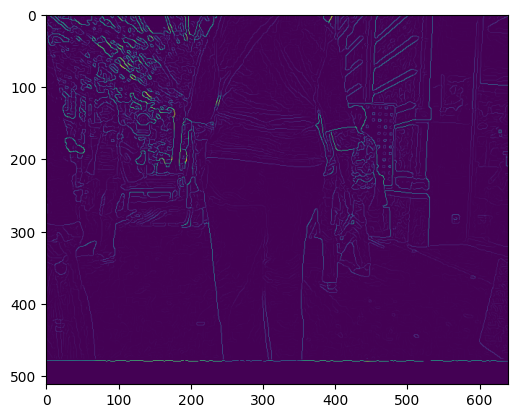

In [5]:
video_path = videos[0]
image_path = os.listdir(video_path)[0]
a = Image.open(f"{video_path}/{image_path}")
b = transform(a).unsqueeze(0).to(device)
img_canny = kornia.filters.canny(b)[0]
import matplotlib.pyplot as plt 
plt.imshow(img_canny[0,0].detach().cpu())

In [6]:
metrics = []
# Compress and decompress




collects = []
results = []
for video_path in videos:
    frames = []
    result = []
    for image_path in os.listdir(video_path):
        a = Image.open(f"{video_path}/{image_path}")
        b = transform(a).unsqueeze(0).to(device)
        frames.append(b)
    print("finished loading frame")
    # Number of pixels in the input image
      # Height * Width * Batch size




    with torch.no_grad():
        strings_list, shapes_list = model.compress(frames)
        print(f"compressed finished")
        x_hat = model.decompress(strings_list, shapes_list)
        print("decompressed finished")
        # Compute bpp
        
        # originals = torch.cat(frames).to(device)
        # decompressed = torch.cat(x_hat).to(device)


    break
    #     x_hat1,x_hat2 = model((frames))
    #     psnr_values = []
    #     ssim_values = []
    #     print(f"x_hat = \n{x_hat1}\n")
    #     print(f"x_hat = \n{x_hat1}\n")
    #     for original, reconstructed in zip(frames, x_hat):
    #         # print(original)
    #         print("\n reconstructed\n")
    #         print(reconstructed)
    #         original = original.squeeze(0)  # Remove batch dimension
    #         reconstructed = reconstructed.squeeze(0)
            
    #         # Calculate PSNR
    #         psnr = metrics.psnr(reconstructed, original, 1.0)
    #         psnr_values.append(psnr.item())
    #         # Calculate SSIM
    #         ssim = metrics.ssim(reconstructed.unsqueeze(0), original.unsqueeze(0), window_size=11)
    #         ssim_values.append(ssim.item())

    #     # Print or store the metrics
    #     print(f"PSNR values: {psnr_values}")
    #     print(f"SSIM values: {ssim_values}\n\n")

    # # Clear memory
    # del frames, results, x_hat
    # torch.cuda.empty_cache()
    # gc.collect()
    # break


finished loading frame
compressed finished
decompressed finished


43

video : MOT17/train/MOT17-05-DPM/img1


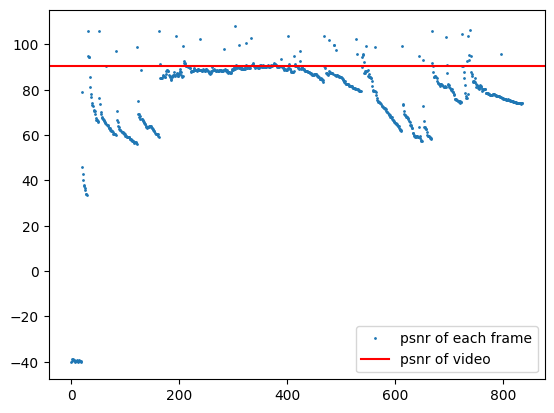

In [20]:
originals = torch.cat(frames).to(device1)
decompressed = torch.cat(x_hat).to(device1)
#metrics
num_pixels = originals.numel()
bpp_value = compute_bpp_from_compressed(strings_list, num_pixels)
psnr_value = psnr(originals,decompressed,1.0)
# ssim_value = ssim(originals,decompressed)
# vif_value = VIF(originals,decompressed)
print(f"video : {video_path}")
metrics.append({"video":video_path,
                "psnr":psnr_value,
                "bpp":bpp_value})
each_psnr = []
for i,x in enumerate(frames):
    each_psnr.append(psnr(frames[i],x_hat[i]))
# print(each_psnr)
import matplotlib.pyplot as plt 
plt.plot(each_psnr,"o",markersize=1,label="psnr of each frame")
plt.axhline(y=psnr_value,color="red",label="psnr of video")
plt.legend()
plt.show()


In [23]:
# print(metrics)
del originals, decompressed
torch.cuda.empty_cache()
gc.collect()
print(metrics)


[{'video': 'MOT17/train/MOT17-05-DPM/img1', 'psnr': 90.35365295410156, 'bpp': 1.6276041666666666e-05}, {'video': 'MOT17/train/MOT17-05-DPM/img1', 'psnr': 90.35365295410156, 'bpp': 1.6276041666666666e-05}, {'video': 'MOT17/train/MOT17-05-DPM/img1', 'psnr': 90.35365295410156, 'bpp': 1.6276041666666666e-05}, {'video': 'MOT17/train/MOT17-05-DPM/img1', 'psnr': 90.35365295410156, 'bpp': 1.6276041666666666e-05}, {'video': 'MOT17/train/MOT17-05-DPM/img1', 'psnr': 90.35365295410156, 'bpp': 1.6276041666666666e-05}, {'video': 'MOT17/train/MOT17-05-DPM/img1', 'psnr': 90.35365295410156, 'bpp': 1.6276041666666666e-05}]


In [24]:
df = pd.DataFrame(metrics)
df["type"]="normal"
print(df)

                           video       psnr       bpp    type
0  MOT17/train/MOT17-05-DPM/img1  90.353653  0.000016  normal
1  MOT17/train/MOT17-05-DPM/img1  90.353653  0.000016  normal
2  MOT17/train/MOT17-05-DPM/img1  90.353653  0.000016  normal
3  MOT17/train/MOT17-05-DPM/img1  90.353653  0.000016  normal
4  MOT17/train/MOT17-05-DPM/img1  90.353653  0.000016  normal
5  MOT17/train/MOT17-05-DPM/img1  90.353653  0.000016  normal


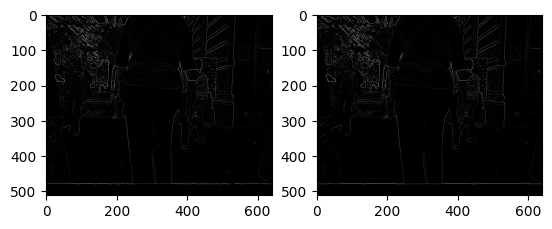

0 is finished
1 is finished
2 is finished
3 is finished
4 is finished
5 is finished
6 is finished
7 is finished
8 is finished
9 is finished
10 is finished
11 is finished
12 is finished
13 is finished
14 is finished
15 is finished
16 is finished
17 is finished
18 is finished
19 is finished
20 is finished
21 is finished
22 is finished
23 is finished
24 is finished
25 is finished
26 is finished
27 is finished
28 is finished
29 is finished
30 is finished
31 is finished
32 is finished
33 is finished
34 is finished
35 is finished
36 is finished
37 is finished
38 is finished
39 is finished
40 is finished
41 is finished
42 is finished
43 is finished
44 is finished
45 is finished
46 is finished
47 is finished
48 is finished
49 is finished
50 is finished
51 is finished
52 is finished
53 is finished
54 is finished
55 is finished
56 is finished
57 is finished
58 is finished
59 is finished
60 is finished
61 is finished
62 is finished
63 is finished
64 is finished
65 is finished
66 is finished
67 is

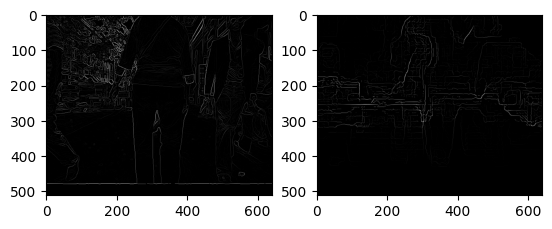

100 is finished
101 is finished
102 is finished
103 is finished
104 is finished
105 is finished
106 is finished
107 is finished
108 is finished
109 is finished
110 is finished
111 is finished
112 is finished
113 is finished
114 is finished
115 is finished
116 is finished
117 is finished
118 is finished
119 is finished
120 is finished
121 is finished
122 is finished
123 is finished
124 is finished
125 is finished
126 is finished
127 is finished
128 is finished
129 is finished
130 is finished
131 is finished
132 is finished
133 is finished
134 is finished
135 is finished
136 is finished
137 is finished
138 is finished
139 is finished
140 is finished
141 is finished
142 is finished
143 is finished
144 is finished
145 is finished
146 is finished
147 is finished
148 is finished
149 is finished
150 is finished
151 is finished
152 is finished
153 is finished
154 is finished
155 is finished
156 is finished
157 is finished
158 is finished
159 is finished
160 is finished
161 is finished
162 is f

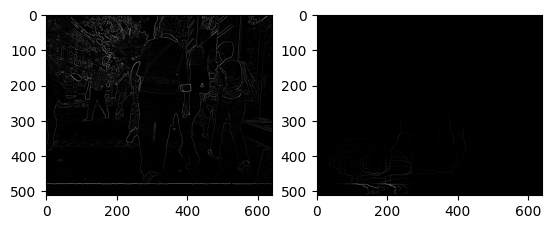

200 is finished
201 is finished
202 is finished
203 is finished
204 is finished
205 is finished
206 is finished
207 is finished
208 is finished
209 is finished
210 is finished
211 is finished
212 is finished
213 is finished
214 is finished
215 is finished
216 is finished
217 is finished
218 is finished
219 is finished
220 is finished
221 is finished
222 is finished
223 is finished
224 is finished
225 is finished
226 is finished
227 is finished
228 is finished
229 is finished
230 is finished
231 is finished
232 is finished
233 is finished
234 is finished
235 is finished
236 is finished
237 is finished
238 is finished
239 is finished
240 is finished
241 is finished
242 is finished
243 is finished
244 is finished
245 is finished
246 is finished
247 is finished
248 is finished
249 is finished
250 is finished
251 is finished
252 is finished
253 is finished
254 is finished
255 is finished
256 is finished
257 is finished
258 is finished
259 is finished
260 is finished
261 is finished
262 is f

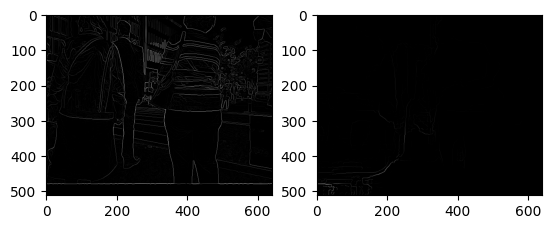

300 is finished
301 is finished
302 is finished
303 is finished
304 is finished
305 is finished
306 is finished
307 is finished
308 is finished
309 is finished
310 is finished
311 is finished
312 is finished
313 is finished
314 is finished
315 is finished
316 is finished
317 is finished
318 is finished
319 is finished
320 is finished
321 is finished
322 is finished
323 is finished
324 is finished
325 is finished
326 is finished
327 is finished
328 is finished
329 is finished
330 is finished
331 is finished
332 is finished
333 is finished
334 is finished
335 is finished
336 is finished
337 is finished
338 is finished
339 is finished
340 is finished
341 is finished
342 is finished
343 is finished
344 is finished
345 is finished
346 is finished
347 is finished
348 is finished
349 is finished
350 is finished
351 is finished
352 is finished
353 is finished
354 is finished
355 is finished
356 is finished
357 is finished
358 is finished
359 is finished
360 is finished
361 is finished
362 is f

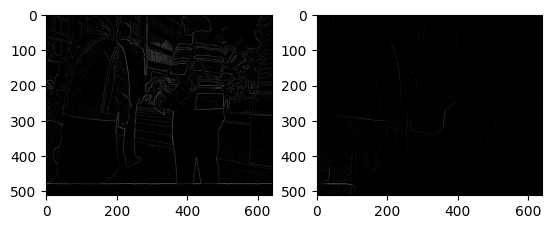

400 is finished
401 is finished
402 is finished
403 is finished
404 is finished
405 is finished
406 is finished
407 is finished
408 is finished
409 is finished
410 is finished
411 is finished
412 is finished
413 is finished
414 is finished
415 is finished
416 is finished
417 is finished
418 is finished
419 is finished
420 is finished
421 is finished
422 is finished
423 is finished
424 is finished
425 is finished
426 is finished
427 is finished
428 is finished
429 is finished
430 is finished
431 is finished
432 is finished
433 is finished
434 is finished
435 is finished
436 is finished
437 is finished
438 is finished
439 is finished
440 is finished
441 is finished
442 is finished
443 is finished
444 is finished
445 is finished
446 is finished
447 is finished
448 is finished
449 is finished
450 is finished
451 is finished
452 is finished
453 is finished
454 is finished
455 is finished
456 is finished
457 is finished
458 is finished
459 is finished
460 is finished
461 is finished
462 is f

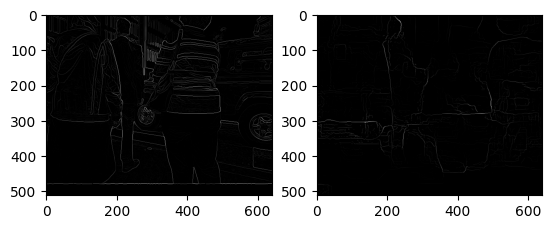

500 is finished
501 is finished
502 is finished
503 is finished
504 is finished
505 is finished
506 is finished
507 is finished
508 is finished
509 is finished
510 is finished
511 is finished
512 is finished
513 is finished
514 is finished
515 is finished
516 is finished
517 is finished
518 is finished
519 is finished
520 is finished
521 is finished
522 is finished
523 is finished
524 is finished
525 is finished
526 is finished
527 is finished
528 is finished
529 is finished
530 is finished
531 is finished
532 is finished
533 is finished
534 is finished
535 is finished
536 is finished
537 is finished
538 is finished
539 is finished
540 is finished
541 is finished
542 is finished
543 is finished
544 is finished
545 is finished
546 is finished
547 is finished
548 is finished
549 is finished
550 is finished
551 is finished
552 is finished
553 is finished
554 is finished
555 is finished
556 is finished
557 is finished
558 is finished
559 is finished
560 is finished
561 is finished
562 is f

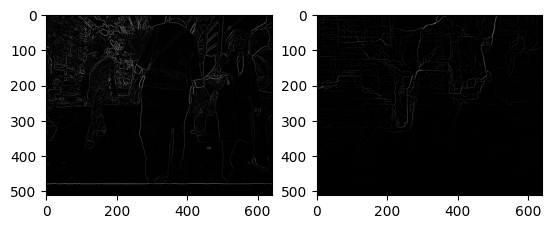

600 is finished
601 is finished
602 is finished
603 is finished
604 is finished
605 is finished
606 is finished
607 is finished
608 is finished
609 is finished
610 is finished
611 is finished
612 is finished
613 is finished
614 is finished
615 is finished
616 is finished
617 is finished
618 is finished
619 is finished
620 is finished
621 is finished
622 is finished
623 is finished
624 is finished
625 is finished
626 is finished
627 is finished
628 is finished
629 is finished
630 is finished
631 is finished
632 is finished
633 is finished
634 is finished
635 is finished
636 is finished
637 is finished
638 is finished
639 is finished
640 is finished
641 is finished
642 is finished
643 is finished
644 is finished
645 is finished
646 is finished
647 is finished
648 is finished
649 is finished
650 is finished
651 is finished
652 is finished
653 is finished
654 is finished
655 is finished
656 is finished
657 is finished
658 is finished
659 is finished
660 is finished
661 is finished
662 is f

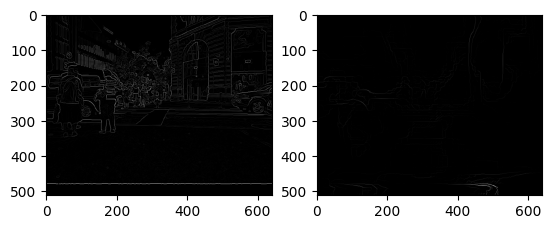

700 is finished
701 is finished
702 is finished
703 is finished
704 is finished
705 is finished
706 is finished
707 is finished
708 is finished
709 is finished
710 is finished
711 is finished
712 is finished
713 is finished
714 is finished
715 is finished
716 is finished
717 is finished
718 is finished
719 is finished
720 is finished
721 is finished
722 is finished
723 is finished
724 is finished
725 is finished
726 is finished
727 is finished
728 is finished
729 is finished
730 is finished
731 is finished
732 is finished
733 is finished
734 is finished
735 is finished
736 is finished
737 is finished
738 is finished
739 is finished
740 is finished
741 is finished
742 is finished
743 is finished
744 is finished
745 is finished
746 is finished
747 is finished
748 is finished
749 is finished
750 is finished
751 is finished
752 is finished
753 is finished
754 is finished
755 is finished
756 is finished
757 is finished
758 is finished
759 is finished
760 is finished
761 is finished
762 is f

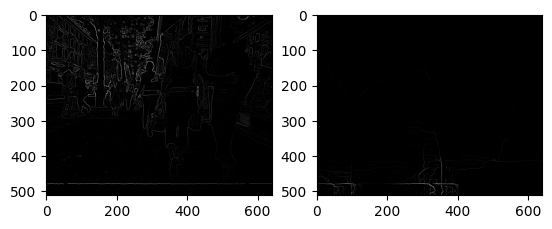

800 is finished
801 is finished
802 is finished
803 is finished
804 is finished
805 is finished
806 is finished
807 is finished
808 is finished
809 is finished
810 is finished
811 is finished
812 is finished
813 is finished
814 is finished
815 is finished
816 is finished
817 is finished
818 is finished
819 is finished
820 is finished
821 is finished
822 is finished
823 is finished
824 is finished
825 is finished
826 is finished
827 is finished
828 is finished
829 is finished
830 is finished
831 is finished
832 is finished
833 is finished
834 is finished
835 is finished
836 is finished


In [35]:

canny_values = []
for i,original in enumerate(frames):
    original = frames[i]
    reconstructed = x_hat[i]
    img_canny = kornia.filters.canny(original)[0]
    img_or = kornia.color.rgb_to_grayscale(original)
    img_canny_compressed = kornia.filters.canny(reconstructed)[0]
    canny_values.append(kornia.metrics.psnr(img_canny,img_canny_compressed,1.0).item())
    if i%100==0:
        plt.subplot(1,2,1)
        plt.imshow(img_canny[0,0].cpu()*1000,cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(img_canny_compressed[0,0].cpu()*1000,cmap="gray")
        plt.show()
    del original, reconstructed
    print(f"{i} is finished")

Text(0.5, 1.0, 'Canny edge detection: original and compressed video using ssf2020,q6')

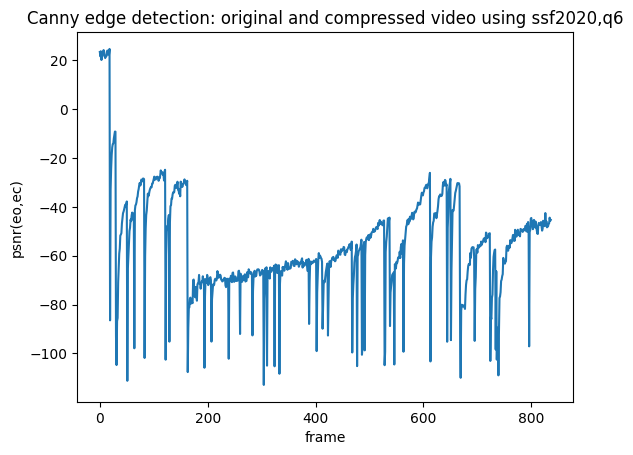

In [54]:
plt.plot(canny_values)
plt.xlabel("frame")
plt.ylabel("psnr(eo,ec)")
plt.title("Canny edge detection: original and compressed video using ssf2020,q6")

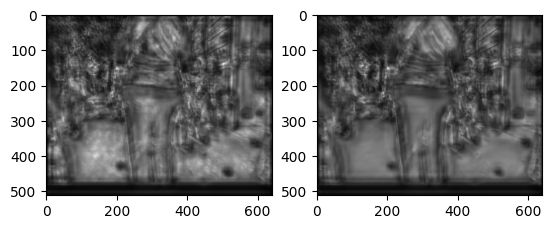

0 is finished
1 is finished
2 is finished
3 is finished
4 is finished
5 is finished
6 is finished
7 is finished
8 is finished
9 is finished
10 is finished
11 is finished
12 is finished
13 is finished
14 is finished
15 is finished
16 is finished
17 is finished
18 is finished
19 is finished
20 is finished
21 is finished
22 is finished
23 is finished
24 is finished
25 is finished
26 is finished
27 is finished
28 is finished
29 is finished
30 is finished
31 is finished
32 is finished
33 is finished
34 is finished
35 is finished
36 is finished
37 is finished
38 is finished
39 is finished
40 is finished
41 is finished
42 is finished
43 is finished
44 is finished
45 is finished
46 is finished
47 is finished
48 is finished
49 is finished
50 is finished
51 is finished
52 is finished
53 is finished
54 is finished
55 is finished
56 is finished
57 is finished
58 is finished
59 is finished
60 is finished
61 is finished
62 is finished
63 is finished
64 is finished
65 is finished
66 is finished
67 is

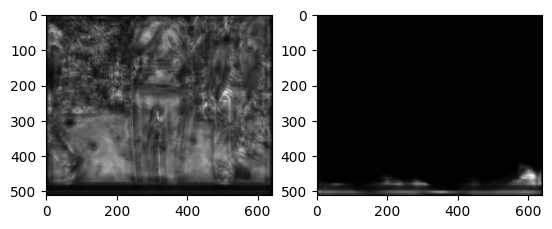

100 is finished
101 is finished
102 is finished
103 is finished
104 is finished
105 is finished
106 is finished
107 is finished
108 is finished
109 is finished
110 is finished
111 is finished
112 is finished
113 is finished
114 is finished
115 is finished
116 is finished
117 is finished
118 is finished
119 is finished
120 is finished
121 is finished
122 is finished
123 is finished
124 is finished
125 is finished
126 is finished
127 is finished
128 is finished
129 is finished
130 is finished
131 is finished
132 is finished
133 is finished
134 is finished
135 is finished
136 is finished
137 is finished
138 is finished
139 is finished
140 is finished
141 is finished
142 is finished
143 is finished
144 is finished
145 is finished
146 is finished
147 is finished
148 is finished
149 is finished
150 is finished
151 is finished
152 is finished
153 is finished
154 is finished
155 is finished
156 is finished
157 is finished
158 is finished
159 is finished
160 is finished
161 is finished
162 is f

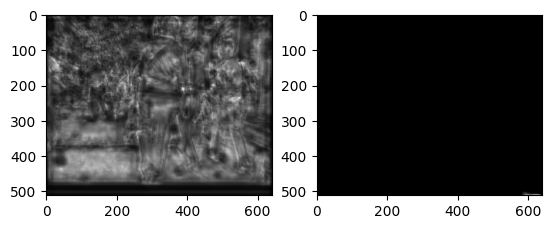

200 is finished
201 is finished
202 is finished
203 is finished
204 is finished
205 is finished
206 is finished
207 is finished
208 is finished
209 is finished
210 is finished
211 is finished
212 is finished
213 is finished
214 is finished
215 is finished
216 is finished
217 is finished
218 is finished
219 is finished
220 is finished
221 is finished
222 is finished
223 is finished
224 is finished
225 is finished
226 is finished
227 is finished
228 is finished
229 is finished
230 is finished
231 is finished
232 is finished
233 is finished
234 is finished
235 is finished
236 is finished
237 is finished
238 is finished
239 is finished
240 is finished
241 is finished
242 is finished
243 is finished
244 is finished
245 is finished
246 is finished
247 is finished
248 is finished
249 is finished
250 is finished
251 is finished
252 is finished
253 is finished
254 is finished
255 is finished
256 is finished
257 is finished
258 is finished
259 is finished
260 is finished
261 is finished
262 is f

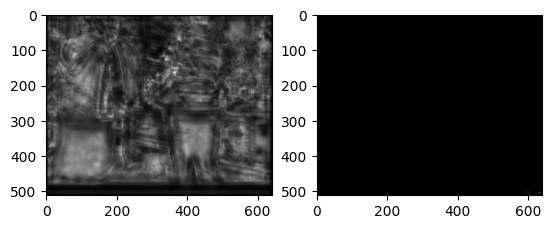

300 is finished
301 is finished
302 is finished
303 is finished
304 is finished
305 is finished
306 is finished
307 is finished
308 is finished
309 is finished
310 is finished
311 is finished
312 is finished
313 is finished
314 is finished
315 is finished
316 is finished
317 is finished
318 is finished
319 is finished
320 is finished
321 is finished
322 is finished
323 is finished
324 is finished
325 is finished
326 is finished
327 is finished
328 is finished
329 is finished
330 is finished
331 is finished
332 is finished
333 is finished
334 is finished
335 is finished
336 is finished
337 is finished
338 is finished
339 is finished
340 is finished
341 is finished
342 is finished
343 is finished
344 is finished
345 is finished
346 is finished
347 is finished
348 is finished
349 is finished
350 is finished
351 is finished
352 is finished
353 is finished
354 is finished
355 is finished
356 is finished
357 is finished
358 is finished
359 is finished
360 is finished
361 is finished
362 is f

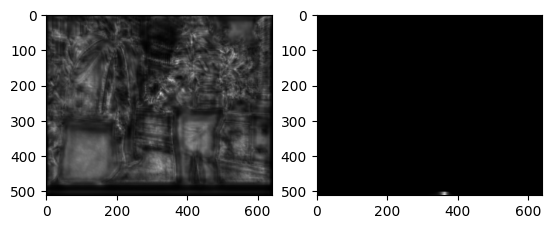

400 is finished
401 is finished
402 is finished
403 is finished
404 is finished
405 is finished
406 is finished
407 is finished
408 is finished
409 is finished
410 is finished
411 is finished
412 is finished
413 is finished
414 is finished
415 is finished
416 is finished
417 is finished
418 is finished
419 is finished
420 is finished
421 is finished
422 is finished
423 is finished
424 is finished
425 is finished
426 is finished
427 is finished
428 is finished
429 is finished
430 is finished
431 is finished
432 is finished
433 is finished
434 is finished
435 is finished
436 is finished
437 is finished
438 is finished
439 is finished
440 is finished
441 is finished
442 is finished
443 is finished
444 is finished
445 is finished
446 is finished
447 is finished
448 is finished
449 is finished
450 is finished
451 is finished
452 is finished
453 is finished
454 is finished
455 is finished
456 is finished
457 is finished
458 is finished
459 is finished
460 is finished
461 is finished
462 is f

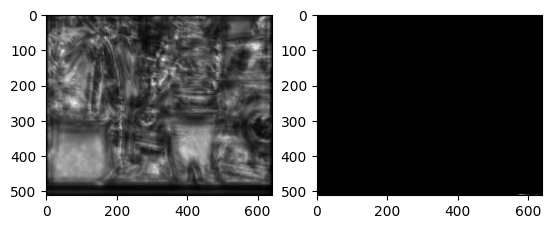

500 is finished
501 is finished
502 is finished
503 is finished
504 is finished
505 is finished
506 is finished
507 is finished
508 is finished
509 is finished
510 is finished
511 is finished
512 is finished
513 is finished
514 is finished
515 is finished
516 is finished
517 is finished
518 is finished
519 is finished
520 is finished
521 is finished
522 is finished
523 is finished
524 is finished
525 is finished
526 is finished
527 is finished
528 is finished
529 is finished
530 is finished
531 is finished
532 is finished
533 is finished
534 is finished
535 is finished
536 is finished
537 is finished
538 is finished
539 is finished
540 is finished
541 is finished
542 is finished
543 is finished
544 is finished
545 is finished
546 is finished
547 is finished
548 is finished
549 is finished
550 is finished
551 is finished
552 is finished
553 is finished
554 is finished
555 is finished
556 is finished
557 is finished
558 is finished
559 is finished
560 is finished
561 is finished
562 is f

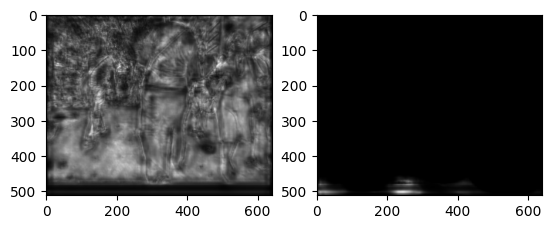

600 is finished
601 is finished
602 is finished
603 is finished
604 is finished
605 is finished
606 is finished
607 is finished
608 is finished
609 is finished
610 is finished
611 is finished
612 is finished
613 is finished
614 is finished
615 is finished
616 is finished
617 is finished
618 is finished
619 is finished
620 is finished
621 is finished
622 is finished
623 is finished
624 is finished
625 is finished
626 is finished
627 is finished
628 is finished
629 is finished
630 is finished
631 is finished
632 is finished
633 is finished
634 is finished
635 is finished
636 is finished
637 is finished
638 is finished
639 is finished
640 is finished
641 is finished
642 is finished
643 is finished
644 is finished
645 is finished
646 is finished
647 is finished
648 is finished
649 is finished
650 is finished
651 is finished
652 is finished
653 is finished
654 is finished
655 is finished
656 is finished
657 is finished
658 is finished
659 is finished
660 is finished
661 is finished
662 is f

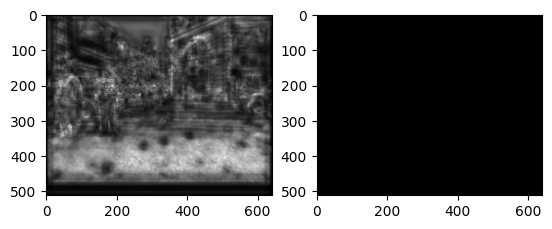

700 is finished
701 is finished
702 is finished
703 is finished
704 is finished
705 is finished
706 is finished
707 is finished
708 is finished
709 is finished
710 is finished
711 is finished
712 is finished
713 is finished
714 is finished
715 is finished
716 is finished
717 is finished
718 is finished
719 is finished
720 is finished
721 is finished
722 is finished
723 is finished
724 is finished
725 is finished
726 is finished
727 is finished
728 is finished
729 is finished
730 is finished
731 is finished
732 is finished
733 is finished
734 is finished
735 is finished
736 is finished
737 is finished
738 is finished
739 is finished
740 is finished
741 is finished
742 is finished
743 is finished
744 is finished
745 is finished
746 is finished
747 is finished
748 is finished
749 is finished
750 is finished
751 is finished
752 is finished
753 is finished
754 is finished
755 is finished
756 is finished
757 is finished
758 is finished
759 is finished
760 is finished
761 is finished
762 is f

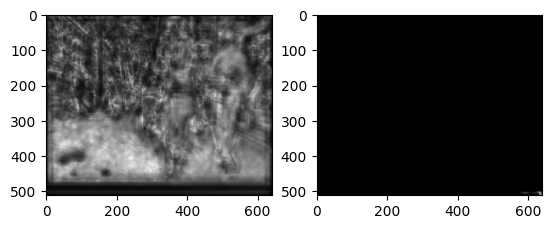

800 is finished
801 is finished
802 is finished
803 is finished
804 is finished
805 is finished
806 is finished
807 is finished
808 is finished
809 is finished
810 is finished
811 is finished
812 is finished
813 is finished
814 is finished
815 is finished
816 is finished
817 is finished
818 is finished
819 is finished
820 is finished
821 is finished
822 is finished
823 is finished
824 is finished
825 is finished
826 is finished
827 is finished
828 is finished
829 is finished
830 is finished
831 is finished
832 is finished
833 is finished
834 is finished
835 is finished
836 is finished


In [39]:

hed_values = []
for i,original in enumerate(frames):
    original = frames[i]
    reconstructed = x_hat[i]
    img_canny = HED_model(original.detach().to(device2))
    img_canny_compressed = HED_model(reconstructed.detach().to(device2))
    hed_values.append(kornia.metrics.psnr(img_canny,img_canny_compressed,1.0).item())
    if i%100==0:
        plt.subplot(1,2,1)
        plt.imshow(img_canny[0,0].detach().cpu()*1000,cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(img_canny_compressed[0,0].detach().cpu()*1000,cmap="gray")
        plt.show()
    del original, reconstructed
    print(f"{i} is finished")

Text(0.5, 1.0, 'HED edge detection: original and compressed video using ssf2020,q6')

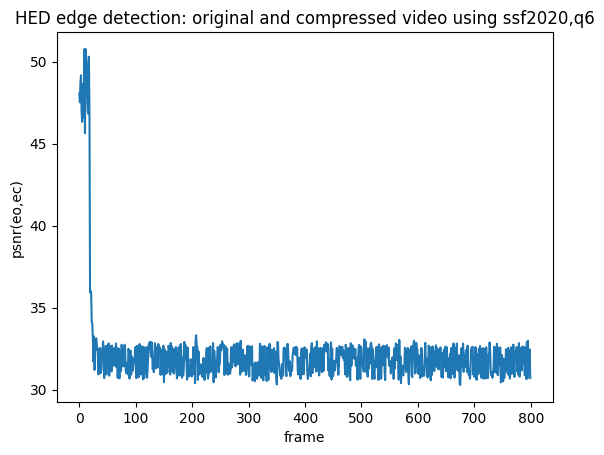

In [56]:
plt.plot(hed_values[:800])
plt.xlabel("frame")
plt.ylabel("psnr(eo,ec)")
plt.title("HED edge detection: original and compressed video using ssf2020,q6")

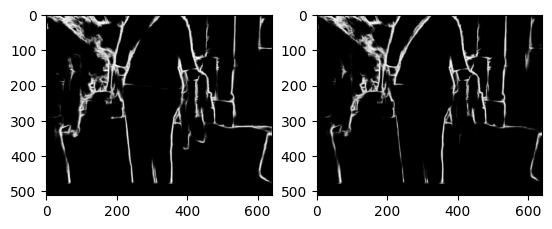

0 is finished
1 is finished
2 is finished
3 is finished
4 is finished
5 is finished
6 is finished
7 is finished
8 is finished
9 is finished
10 is finished
11 is finished
12 is finished
13 is finished
14 is finished
15 is finished
16 is finished
17 is finished
18 is finished
19 is finished
20 is finished
21 is finished
22 is finished
23 is finished
24 is finished
25 is finished
26 is finished
27 is finished
28 is finished
29 is finished
30 is finished
31 is finished
32 is finished
33 is finished
34 is finished
35 is finished
36 is finished
37 is finished
38 is finished
39 is finished
40 is finished
41 is finished
42 is finished
43 is finished
44 is finished
45 is finished
46 is finished
47 is finished
48 is finished
49 is finished
50 is finished
51 is finished
52 is finished
53 is finished
54 is finished
55 is finished
56 is finished
57 is finished
58 is finished
59 is finished
60 is finished
61 is finished
62 is finished
63 is finished
64 is finished
65 is finished
66 is finished
67 is

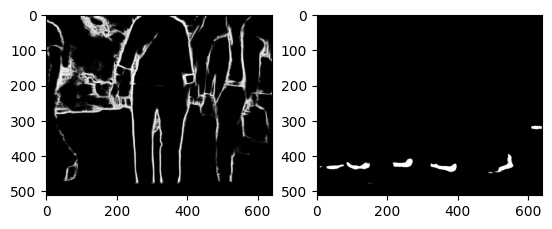

100 is finished
101 is finished
102 is finished
103 is finished
104 is finished
105 is finished
106 is finished
107 is finished
108 is finished
109 is finished
110 is finished
111 is finished
112 is finished
113 is finished
114 is finished
115 is finished
116 is finished
117 is finished
118 is finished
119 is finished
120 is finished
121 is finished
122 is finished
123 is finished
124 is finished
125 is finished
126 is finished
127 is finished
128 is finished
129 is finished
130 is finished
131 is finished
132 is finished
133 is finished
134 is finished
135 is finished
136 is finished
137 is finished
138 is finished
139 is finished
140 is finished
141 is finished
142 is finished
143 is finished
144 is finished
145 is finished
146 is finished
147 is finished
148 is finished
149 is finished
150 is finished
151 is finished
152 is finished
153 is finished
154 is finished
155 is finished
156 is finished
157 is finished
158 is finished
159 is finished
160 is finished
161 is finished
162 is f

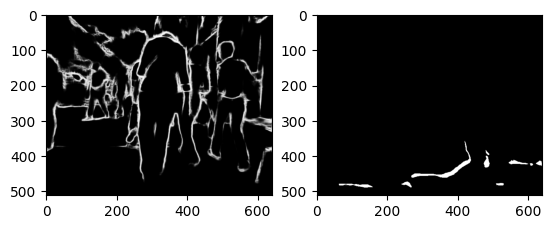

200 is finished
201 is finished
202 is finished
203 is finished
204 is finished
205 is finished
206 is finished
207 is finished
208 is finished
209 is finished
210 is finished
211 is finished
212 is finished
213 is finished
214 is finished
215 is finished
216 is finished
217 is finished
218 is finished
219 is finished
220 is finished
221 is finished
222 is finished
223 is finished
224 is finished
225 is finished
226 is finished
227 is finished
228 is finished
229 is finished
230 is finished
231 is finished
232 is finished
233 is finished
234 is finished
235 is finished
236 is finished
237 is finished
238 is finished
239 is finished
240 is finished
241 is finished
242 is finished
243 is finished
244 is finished
245 is finished
246 is finished
247 is finished
248 is finished
249 is finished
250 is finished
251 is finished
252 is finished
253 is finished
254 is finished
255 is finished
256 is finished
257 is finished
258 is finished
259 is finished
260 is finished
261 is finished
262 is f

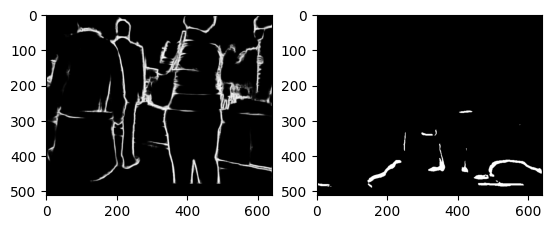

300 is finished
301 is finished
302 is finished
303 is finished
304 is finished
305 is finished
306 is finished
307 is finished
308 is finished
309 is finished
310 is finished
311 is finished
312 is finished
313 is finished
314 is finished
315 is finished
316 is finished
317 is finished
318 is finished
319 is finished
320 is finished
321 is finished
322 is finished
323 is finished
324 is finished
325 is finished
326 is finished
327 is finished
328 is finished
329 is finished
330 is finished
331 is finished
332 is finished
333 is finished
334 is finished
335 is finished
336 is finished
337 is finished
338 is finished
339 is finished
340 is finished
341 is finished
342 is finished
343 is finished
344 is finished
345 is finished
346 is finished
347 is finished
348 is finished
349 is finished
350 is finished
351 is finished
352 is finished
353 is finished
354 is finished
355 is finished
356 is finished
357 is finished
358 is finished
359 is finished
360 is finished
361 is finished
362 is f

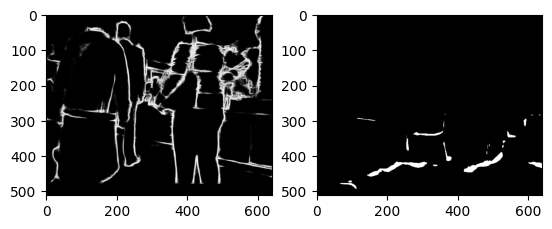

400 is finished
401 is finished
402 is finished
403 is finished
404 is finished
405 is finished
406 is finished
407 is finished
408 is finished
409 is finished
410 is finished
411 is finished
412 is finished
413 is finished
414 is finished
415 is finished
416 is finished
417 is finished
418 is finished
419 is finished
420 is finished
421 is finished
422 is finished
423 is finished
424 is finished
425 is finished
426 is finished
427 is finished
428 is finished
429 is finished
430 is finished
431 is finished
432 is finished
433 is finished
434 is finished
435 is finished
436 is finished
437 is finished
438 is finished
439 is finished
440 is finished
441 is finished
442 is finished
443 is finished
444 is finished
445 is finished
446 is finished
447 is finished
448 is finished
449 is finished
450 is finished
451 is finished
452 is finished
453 is finished
454 is finished
455 is finished
456 is finished
457 is finished
458 is finished
459 is finished
460 is finished
461 is finished
462 is f

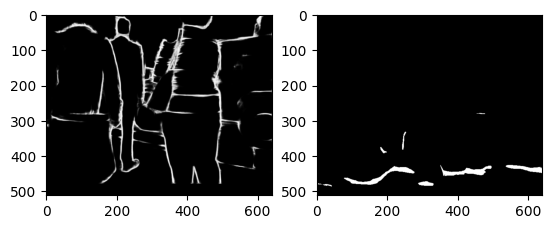

500 is finished
501 is finished
502 is finished
503 is finished
504 is finished
505 is finished
506 is finished
507 is finished
508 is finished
509 is finished
510 is finished
511 is finished
512 is finished
513 is finished
514 is finished
515 is finished
516 is finished
517 is finished
518 is finished
519 is finished
520 is finished
521 is finished
522 is finished
523 is finished
524 is finished
525 is finished
526 is finished
527 is finished
528 is finished
529 is finished
530 is finished
531 is finished
532 is finished
533 is finished
534 is finished
535 is finished
536 is finished
537 is finished
538 is finished
539 is finished
540 is finished
541 is finished
542 is finished
543 is finished
544 is finished
545 is finished
546 is finished
547 is finished
548 is finished
549 is finished
550 is finished
551 is finished
552 is finished
553 is finished
554 is finished
555 is finished
556 is finished
557 is finished
558 is finished
559 is finished
560 is finished
561 is finished
562 is f

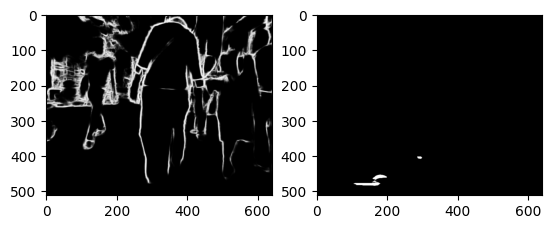

600 is finished
601 is finished
602 is finished
603 is finished
604 is finished
605 is finished
606 is finished
607 is finished
608 is finished
609 is finished
610 is finished
611 is finished
612 is finished
613 is finished
614 is finished
615 is finished
616 is finished
617 is finished
618 is finished
619 is finished
620 is finished
621 is finished
622 is finished
623 is finished
624 is finished
625 is finished
626 is finished
627 is finished
628 is finished
629 is finished
630 is finished
631 is finished
632 is finished
633 is finished
634 is finished
635 is finished
636 is finished
637 is finished
638 is finished
639 is finished
640 is finished
641 is finished
642 is finished
643 is finished
644 is finished
645 is finished
646 is finished
647 is finished
648 is finished
649 is finished
650 is finished
651 is finished
652 is finished
653 is finished
654 is finished
655 is finished
656 is finished
657 is finished
658 is finished
659 is finished
660 is finished
661 is finished
662 is f

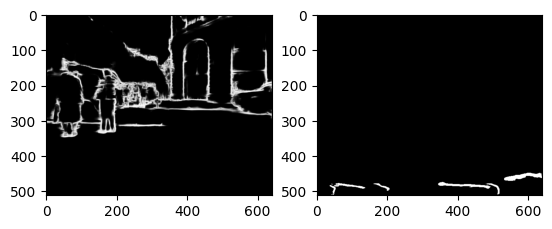

700 is finished
701 is finished
702 is finished
703 is finished
704 is finished
705 is finished
706 is finished
707 is finished
708 is finished
709 is finished
710 is finished
711 is finished
712 is finished
713 is finished
714 is finished
715 is finished
716 is finished
717 is finished
718 is finished
719 is finished
720 is finished
721 is finished
722 is finished
723 is finished
724 is finished
725 is finished
726 is finished
727 is finished
728 is finished
729 is finished
730 is finished
731 is finished
732 is finished
733 is finished
734 is finished
735 is finished
736 is finished
737 is finished
738 is finished
739 is finished
740 is finished
741 is finished
742 is finished
743 is finished
744 is finished
745 is finished
746 is finished
747 is finished
748 is finished
749 is finished
750 is finished
751 is finished
752 is finished
753 is finished
754 is finished
755 is finished
756 is finished
757 is finished
758 is finished
759 is finished
760 is finished
761 is finished
762 is f

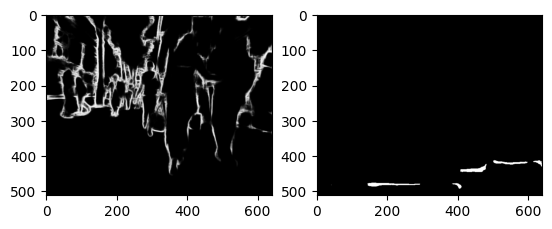

800 is finished
801 is finished
802 is finished
803 is finished
804 is finished
805 is finished
806 is finished
807 is finished
808 is finished
809 is finished
810 is finished
811 is finished
812 is finished
813 is finished
814 is finished
815 is finished
816 is finished
817 is finished
818 is finished
819 is finished
820 is finished
821 is finished
822 is finished
823 is finished
824 is finished
825 is finished
826 is finished
827 is finished
828 is finished
829 is finished
830 is finished
831 is finished
832 is finished
833 is finished
834 is finished
835 is finished
836 is finished


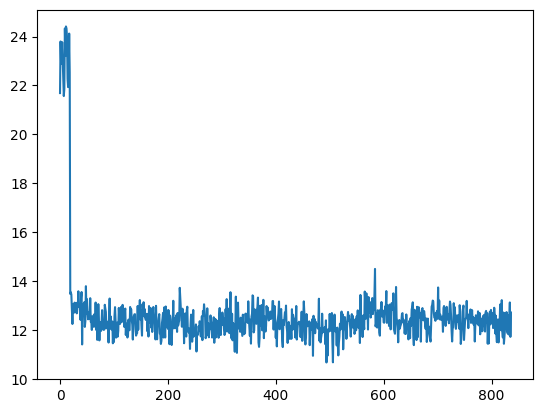

In [51]:

ehed_values = []
for i,original in enumerate(frames):
    original = frames[i]
    reconstructed = x_hat[i]
    img_canny,_ = EnhancedHED_model(original.detach().to(device2))
    img_canny_compressed,_ = EnhancedHED_model(reconstructed.detach().to(device2))
    ehed_values.append(kornia.metrics.psnr(img_canny,img_canny_compressed,1.0).item())
    if i%100==0:
        plt.subplot(1,2,1)
        plt.imshow(img_canny[0,0].detach().cpu()*1000,cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(img_canny_compressed[0,0].detach().cpu()*1000,cmap="gray")
        plt.show()
    del original, reconstructed
    print(f"{i} is finished")



Text(0.5, 1.0, 'HED variant edge detection: original and compressed video using ssf2020,q6')

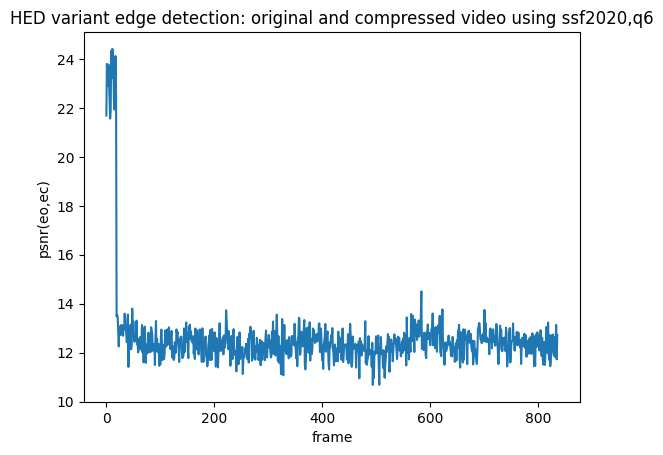

In [57]:
plt.plot(ehed_values)
plt.xlabel("frame")
plt.ylabel("psnr(eo,ec)")
plt.title("HED variant edge detection: original and compressed video using ssf2020,q6")